In [4]:
from __future__ import annotations
from PythonTools.ezrt_header import EzrtHeader
from pathlib import Path
import matplotlib.pyplot as plt
import time
import numpy as np
from PythonTools.raw2py import raw2py
from PythonTools.py2rek import py2rek
import astra

In [5]:
# Measurement parameters
n_projections = 200 # Number of projections
n_detectors_pixels_height= 1984
n_detectors_pixels_width= 1984 # Number of detectors
projection_path = r"/home/abtin/CT+Ultrasound/Reconstruction/steal_real_v1_with_ArbitraryGeometry_from_SouvListRotReal/projection_"
reconstruction_path = r"/home/abtin/CT+Ultrasound/Reconstruction/steal_real_v1/Steel_Real.rek"

In [6]:
volume_center_position_in_micrometer = [0.0, 0.0, 20000.0]
volume_voxel_count = [384,1024,384]
volume_voxel_size_in_micrometer = 145
DetectorSpacing_X_in_micrometer = 200 
DetectorSpacing_Y_in_micrometer = 200  

# Define volume geometry for reconstruction

vol_geom = astra.creators.create_vol_geom(
    volume_voxel_count[1],#n_rows
    volume_voxel_count[0],#n_cols
    volume_voxel_count[2],#n_slices
    volume_center_position_in_micrometer[0] - volume_voxel_count[0]/2 * volume_voxel_size_in_micrometer,#min_x
    volume_center_position_in_micrometer[0] + volume_voxel_count[0]/2 * volume_voxel_size_in_micrometer,#max_x
    volume_center_position_in_micrometer[1] - volume_voxel_count[1]/2 * volume_voxel_size_in_micrometer,#min_y
    volume_center_position_in_micrometer[1] + volume_voxel_count[1]/2 * volume_voxel_size_in_micrometer,#max_y
    volume_center_position_in_micrometer[2] - volume_voxel_count[2]/2 * volume_voxel_size_in_micrometer,#min_z
    volume_center_position_in_micrometer[2] + volume_voxel_count[2]/2 * volume_voxel_size_in_micrometer)#max_z

# Initialize vectors matrix (n_projections x 12)
vectors = np.zeros((n_projections, 12))


sinogram = np.zeros((n_detectors_pixels_height,n_projections,n_detectors_pixels_width))


In [7]:
 # Fill the vectors as per ASTRA's vector structure
i_0 = 42881
for i in range(n_projections):
    
    #file_name = projection_path + str(i).zfill(4) + '.raw'
    file_name = str(projection_path) + str(i).zfill(4) + ".raw"
    projection_file = raw2py(file_name)
  
# Access raw intensity data (projection_file[1] may be raw data)
    raw_intensity_data = projection_file[1]
    
    # Apply Lambert-Beer law:
    transformed_projection = np.log(i_0/raw_intensity_data)

    sinogram[:,i,:] = transformed_projection

    # Get the source position coordinates in meters
    source_x, source_y, source_z = projection_file[0].agv_source_position

    # Convert each coordinate to micrometers
    source_x_micrometers = source_x #* 1e6
    source_y_micrometers = source_y #* 1e6
    source_z_micrometers = source_z #* 1e6

    # Get the detector center coordinates in meters
    det_center_x, det_center_y, det_center_z = projection_file[0].agv_detector_center_position

    # Convert each coordinate to micrometers
    det_center_x_micrometers = det_center_x #* 1e6
    det_center_y_micrometers = det_center_y #* 1e6
    det_center_z_micrometers = det_center_z #* 1e6

     # Multiplying detector column direction with size of pixels
    detector_col_direction_x, detector_col_direction_y, detector_col_direction_z = projection_file[0].agv_detector_col_direction

    
    detector_col_direction_x_with_pixels = -detector_col_direction_x * DetectorSpacing_Y_in_micrometer
    detector_col_direction_y_with_pixels = -detector_col_direction_y * DetectorSpacing_Y_in_micrometer
    detector_col_direction_z_with_pixels = -detector_col_direction_z * DetectorSpacing_Y_in_micrometer

    # Multiplying detector line direction with size of pixels
    detector_line_direction_x, detector_line_direction_y, detector_line_direction_z = projection_file[0].agv_detector_line_direction


    detector_line_direction_x_with_pixels = detector_line_direction_x * DetectorSpacing_X_in_micrometer
    detector_line_direction_y_with_pixels = detector_line_direction_y * DetectorSpacing_X_in_micrometer
    detector_line_direction_z_with_pixels = detector_line_direction_z * DetectorSpacing_X_in_micrometer


    vectors[i, 0] = source_x_micrometers #for x 
    vectors[i, 1] = source_y_micrometers#For y
    vectors[i, 2] = source_z_micrometers #For z



    # center of detector
    vectors[i, 3] = det_center_x_micrometers #for x 
    vectors[i, 4] = det_center_y_micrometers #For y
    vectors[i, 5] = det_center_z_micrometers #For z


    # vector from detector pixel (0,0) to (0,1)
    vectors[i, 6] = detector_line_direction_x_with_pixels  #for x 
    vectors[i, 7] = detector_line_direction_y_with_pixels  #For y
    vectors[i, 8] = detector_line_direction_z_with_pixels  #For z

    # vector from detector pixel (0,0) to (1,0)
    vectors[i, 9] =  detector_col_direction_x_with_pixels #for x 
    vectors[i, 10] = detector_col_direction_y_with_pixels #For y
    vectors[i, 11] = detector_col_direction_z_with_pixels #For z
     
proj_geom = astra.create_proj_geom('cone_vec',  
                                   n_detectors_pixels_width,#det_row_count: number of detector rows in a single projection
                                   n_detectors_pixels_height,#det_col_count: number of detector columns in a single projection
                                    vectors) #vectors: a matrix containing the actual geometry

In [8]:
print(sinogram.shape)

(1984, 200, 1984)


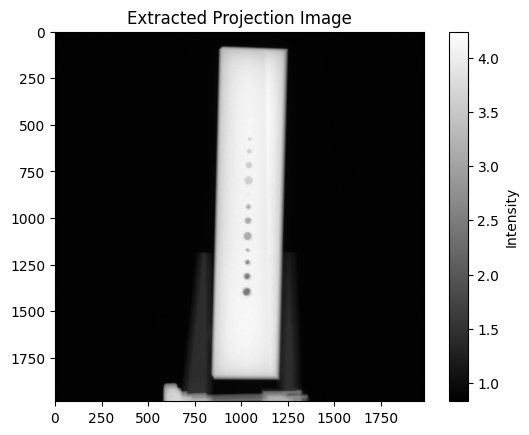

In [9]:
import matplotlib.pyplot as plt

# Suppose raw_intensity_data is one of your projection images
plt.figure()
plt.imshow(transformed_projection, cmap='gray')
plt.title("Extracted Projection Image")
plt.colorbar(label='Intensity')
plt.show()


In [10]:
proj_id = astra.data3d.create('-sino',proj_geom, sinogram)

In [ ]:
# Set up and run the SIRT3D-CUDA reconstruction algorithm
reconstruction_id = astra.data3d.create('-vol', vol_geom)
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ProjectionDataId'] = proj_id
cfg['ReconstructionDataId'] = reconstruction_id
#cfg['option'] = {'MinConstraint': 0}  # Ensure non-negative values in the reconstruction

# Create and run the reconstruction algorithm
algo_id = astra.algorithm.create(cfg)
astra.algorithm.run(algo_id, 1)  # Run for 100 iterations (you can adjust this number)

# Get the reconstructed volume
reconstructed_volume = astra.data3d.get(reconstruction_id)

# Clean up memory
astra.algorithm.delete(algo_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(proj_id)

# Save or further process the reconstructed volume
print("Reconstruction complete. Volume shape:", reconstructed_volume.shape)

In [26]:
py2rek(reconstructed_volume, reconstruction_path) # type: ignore


In [23]:
import SimpleITK as sitk
def save_as_nii(volume, filename='reconstructed_volume.nii'):
    """Save the reconstructed volume as a NIfTI (.nii) file."""
    sitk_volume = sitk.GetImageFromArray(volume)
    sitk.WriteImage(sitk_volume, filename)
    print(f"Reconstructed volume saved as {filename}")
save_as_nii(reconstructed_volume, 'Real_Steel_req_V2.nii'

SyntaxError: unexpected EOF while parsing (3923387883.py, line 7)